In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import cityImage as ci

from shapely.geometry import Point, mapping
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")
pd.options.display.float_format = '{:20.2f}'.format
pd.options.mode.chained_assignment = None

**Ininitialising path, names, etc.**

In [2]:
city_name = 'Torino'
epsg = 3003
crs = 'EPSG:'+str(epsg)
place = 'Torino, Italy'
input_path = '../data/'+city_name

## Nodes and Dual Network From OSM data
### Download and preparation
Choose the name of the place that represent your case-study area. When the case-study area does not coincide with the entire extension of a city, it is suggested to include the case-study area's surroundings (e.g. buffer of 2000 mt from the centre of the area, depending on its extension) so to avoid the edge effect when computing the centrality measures.

Choose between the following methods:
* `OSMplace`, providing an OSM place name (e.g. City).
* `OSMpolygon`, provide a Polygon (coordinates must be in units of latitude-longitude degrees).
* `distance_from_address`, providing a precise address and setting the `distance` parameter (which is otherwise not necessary)

In [3]:
download_method = 'distance_from_address'
place = 'Piazza Castello, Torino'
distance = 2500

nodes_graph, edges_graph = ci.get_pedestrian_network_fromOSM(place, download_method, distance = distance, epsg = epsg)
edges_graph['lit'] = np.where(edges_graph['lit'].isna(), 9999, np.where(edges_graph['lit'] == 'no', 0, 1))

### Cleaning and simplyfing the Street Network

At the end of the previous section two files are obtained: nodes and edges (vertexes and links). Below, before creating the actual graph, the two datasets are cleaned, simplified and corrected.

Cleaning functions handle (through boolean parameters):
* Duplicate geometries (nodes, edges).
* Pseudo-nodes.
* `remove_islands`: Disconnected islands.
* `dead_ends` Dead-end street segments.
* `self_loops` Self-Loops.
* `same_vertexes_edges` Edges with same from-to nodes, but different geometries.
* `fix_topology` This creates nodes and breaks street segments at intersections. It is primarily useful for poorly formed datasets (usually OSM deerived networks are topologically correct). It accounts for segments classified as bridges or tunnels in OSM.

`same_vertexes_edges` handles edges with same pair of u-v nodes but different geometries. When `True`, it derives a center line between the two segments, unless one of the two segments is longer than the other (>10%). In this case, the shorter segment is deleted.

In [4]:
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = False, remove_islands = True,
                            same_vertexes_edges = True, self_loops = True, fix_topology = True)
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_islands = False,
                            same_vertexes_edges = False, self_loops = True, fix_topology = False)
# nodes_graph, edges_graph = ci.consolidate_nodes(nodes_graph, edges_graph, True, 5)

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\shapely\linear.py:88: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)
C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)
C:\Users\gfilo\AppDa

In [9]:
nodes_graph, edges_graph = ci.consolidate_nodes(nodes_graph, edges_graph, True, 5)

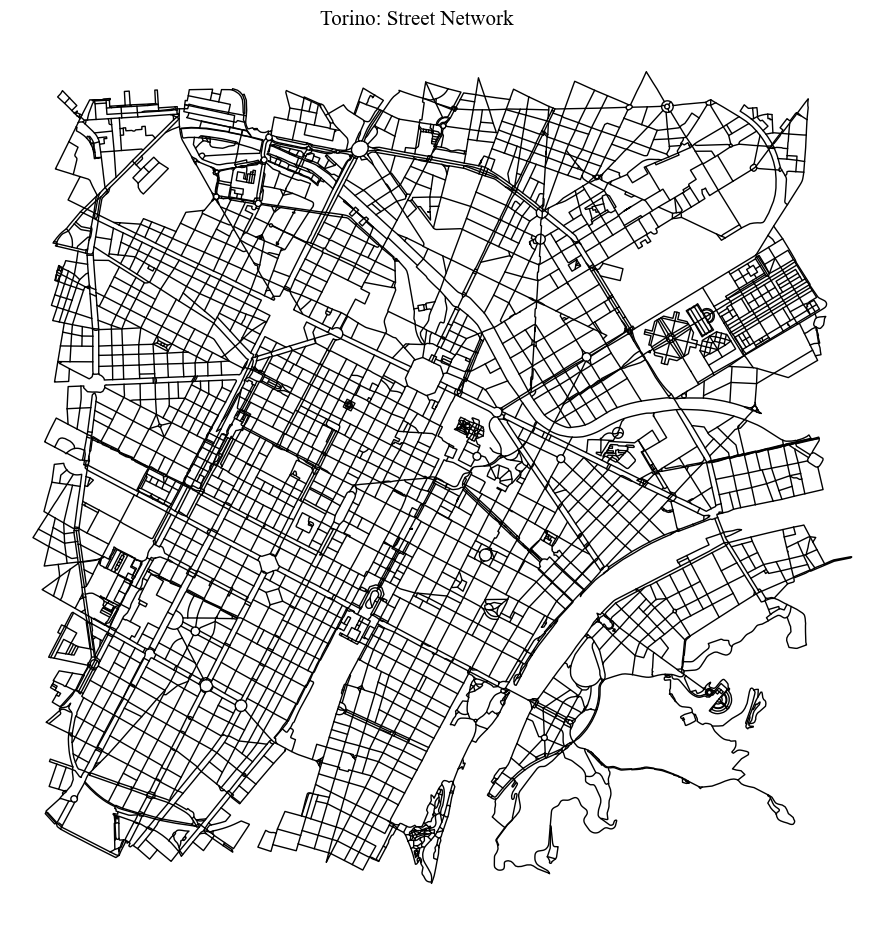

In [10]:
plot = ci.plot_gdf(edges_graph, black_background = False, figsize = (10,10), title = city_name+': Street Network',
                   color = 'black')

### Node centrality

Betweenness centrality is used to model nodes' hierarchies and identify salient nodes in the network.

In [12]:
# Obtaining the graph from the case-study area and computing the centrality measures
graph = ci.graph_fromGDF(nodes_graph, edges_graph)

# betweenness centrality
Bc_Rd = ci.calculate_centrality(nx_graph = graph, measure ='betweenness', weight='length')
nodes_graph['Bc_Rd'] = nodes_graph.nodeID.map(Bc_Rd)

#### Visualisation

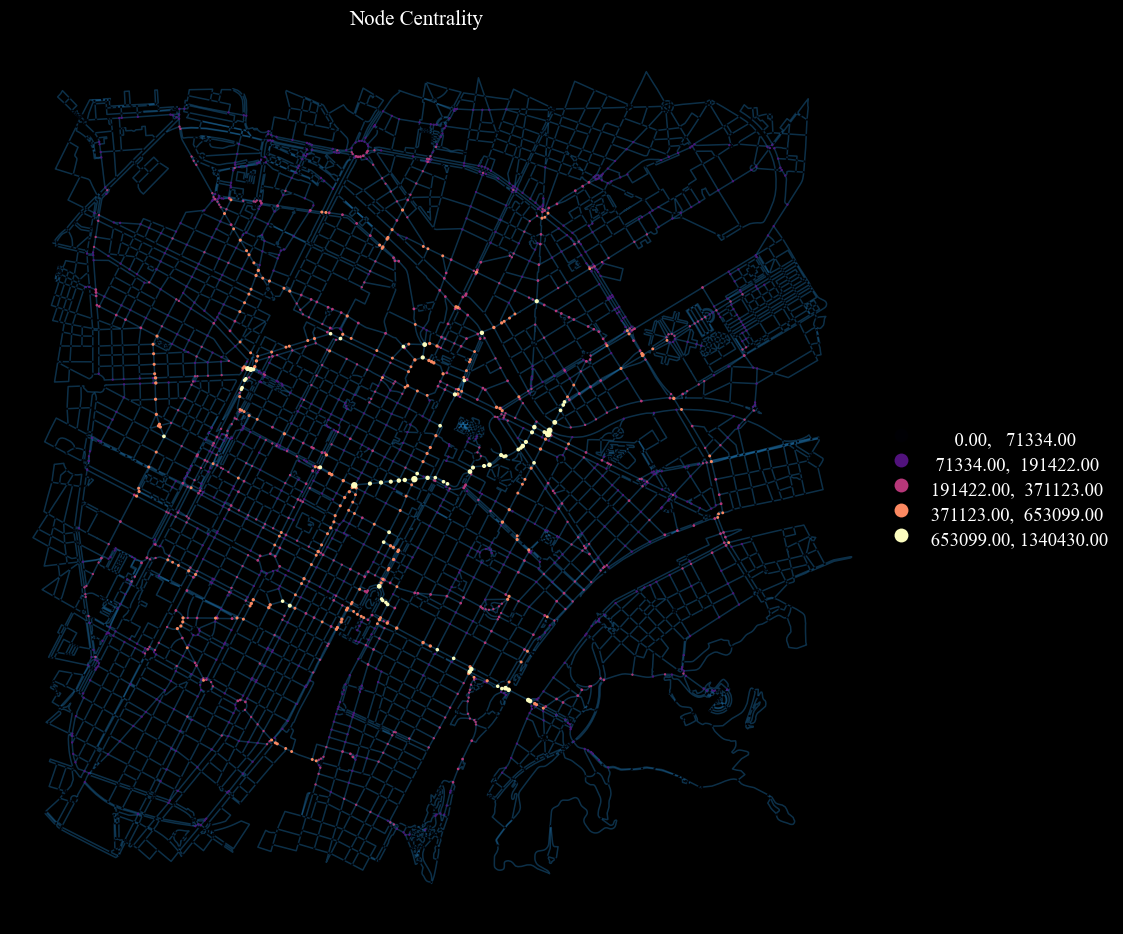

In [13]:
fig = ci.plot_gdf(nodes_graph, column = 'Bc_Rd', title =  "Node Centrality", cmap = 'magma', classes = 5, scheme = 'natural_breaks',
            geometry_size_factor = 3.6, figsize = (10, 10), base_map_gdf = edges_graph, base_map_zorder = 0, 
            legend = True)

### Dual graph analysis

Here street-segments are transformed into nodes (geograpically represented by their centroids). Fictional links represent instead intersections. Thus if two segments are connected in the actual street network, a link in the dual graph representation will be created by connecting the corresponding nodes. This process allows taking advantage of angular relationships in centrality measures computation and other network operations.

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\cityImage\graph.py:183: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edges_dual = pd.concat([edges_dual, new_row], ignore_index=True)


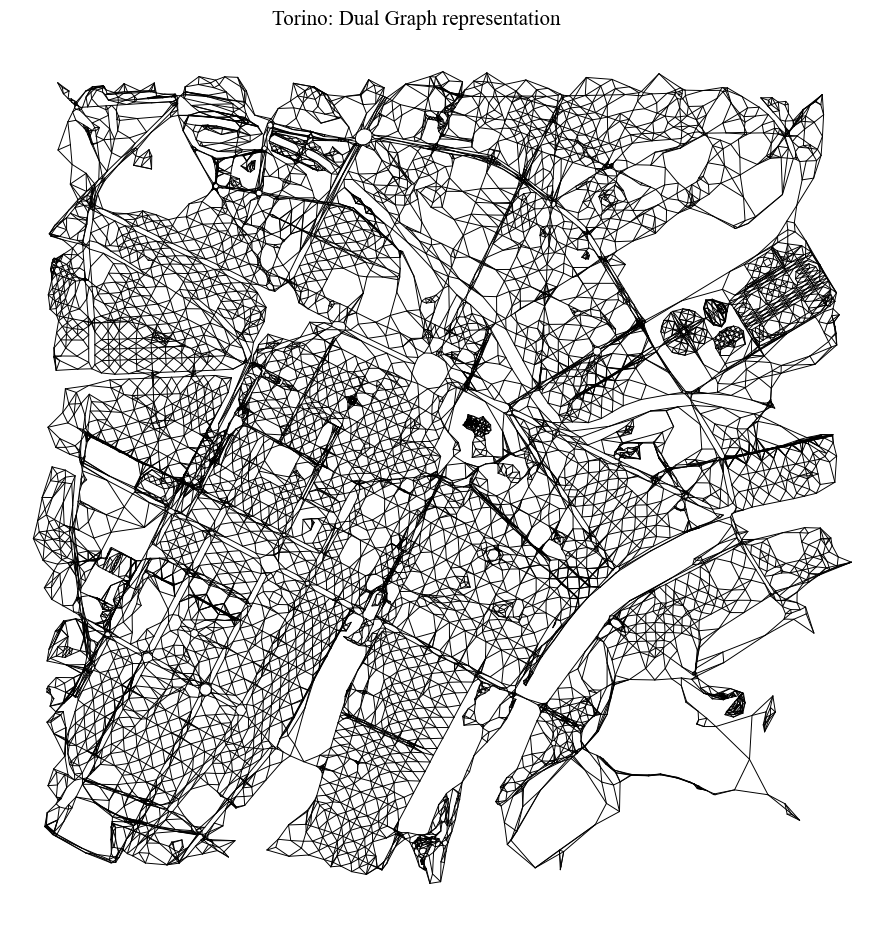

In [14]:
# Creating the dual geodataframes and the dual graph.
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)
plot = ci.plot_gdf(edgesDual_graph, black_background = False, figsize = (10,10), title = city_name+': Dual Graph representation', 
             color = 'black', geometry_size = 0.7)

## Districts Identification
### Download and preparation

In [16]:
place = 'Torino, Italy'
download_method = 'OSMplace'
distance = None

nodes_graph_drive, edges_graph_drive = ci.get_network_fromOSM(place, download_method, 'drive', epsg, distance = distance)

nodes_graph_drive, edges_graph_drive  = ci.clean_network(nodes_graph_drive, edges_graph_drive, dead_ends = False, remove_islands = True,
                            same_vertexes_edges = False, self_loops = True, fix_topology = False)

In [17]:
nodesDual_graph_drive, edgesDual_graph_drive = ci.dual_gdf(nodes_graph_drive, edges_graph_drive, epsg)

# creating the dual_graph
dual_graph_drive = ci.dual_graph_fromGDF(nodesDual_graph_drive, edgesDual_graph_drive)

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\cityImage\graph.py:183: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edges_dual = pd.concat([edges_dual, new_row], ignore_index=True)


### Computation

In [18]:
weights = ['length', 'rad', None]
districts = edges_graph_drive.copy()
for weight in weights:
    districts = ci.identify_regions(dual_graph_drive, districts, weight = weight)

**Visualisation**

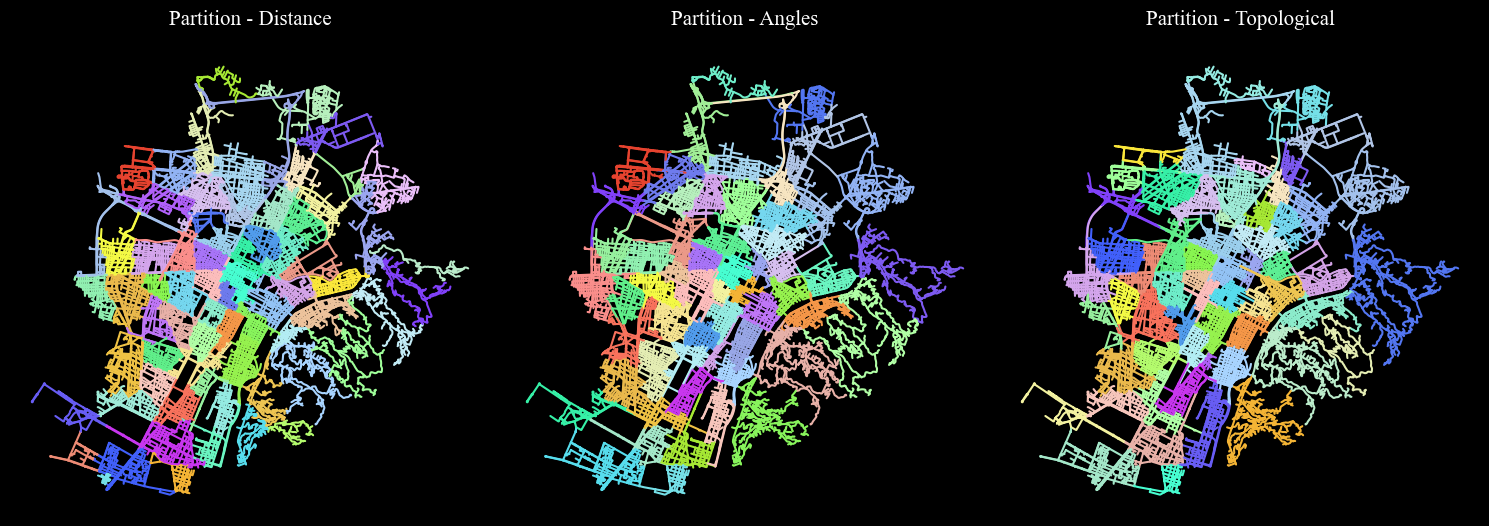

In [19]:
columns = ['p_length','p_rad', 'p_topo']
titles = ['Partition - Distance', 'Partition - Angles', 'Partition - Topological']

nlabels = max([len(districts[column].unique()) for column in columns])
cmap = ci.rand_cmap(nlabels = nlabels, type_color='bright')
fig = ci.plot_grid_gdf_columns(districts, columns = columns, titles = titles, geometry_size = 1.5, cmap = cmap, black_background = True, 
                  legend = False, figsize = (15, 10), ncols = 3, nrows = 1)

### Assigning Regions to the Pedestrian Network

In [20]:
# choosing the type of partition to be used
column = 'p_rad'
min_size_district = 20
dc = dict(districts[column].value_counts())

## ignore small portions
to_ignore = {k: v for k, v in dc.items() if v <= min_size_district} 
tmp = districts[~((districts[column].isin(to_ignore))| (districts[column] == 999999))].copy()

partitions = ci.polygonise_partitions(tmp, column, convex_hull = False, buffer = 5)

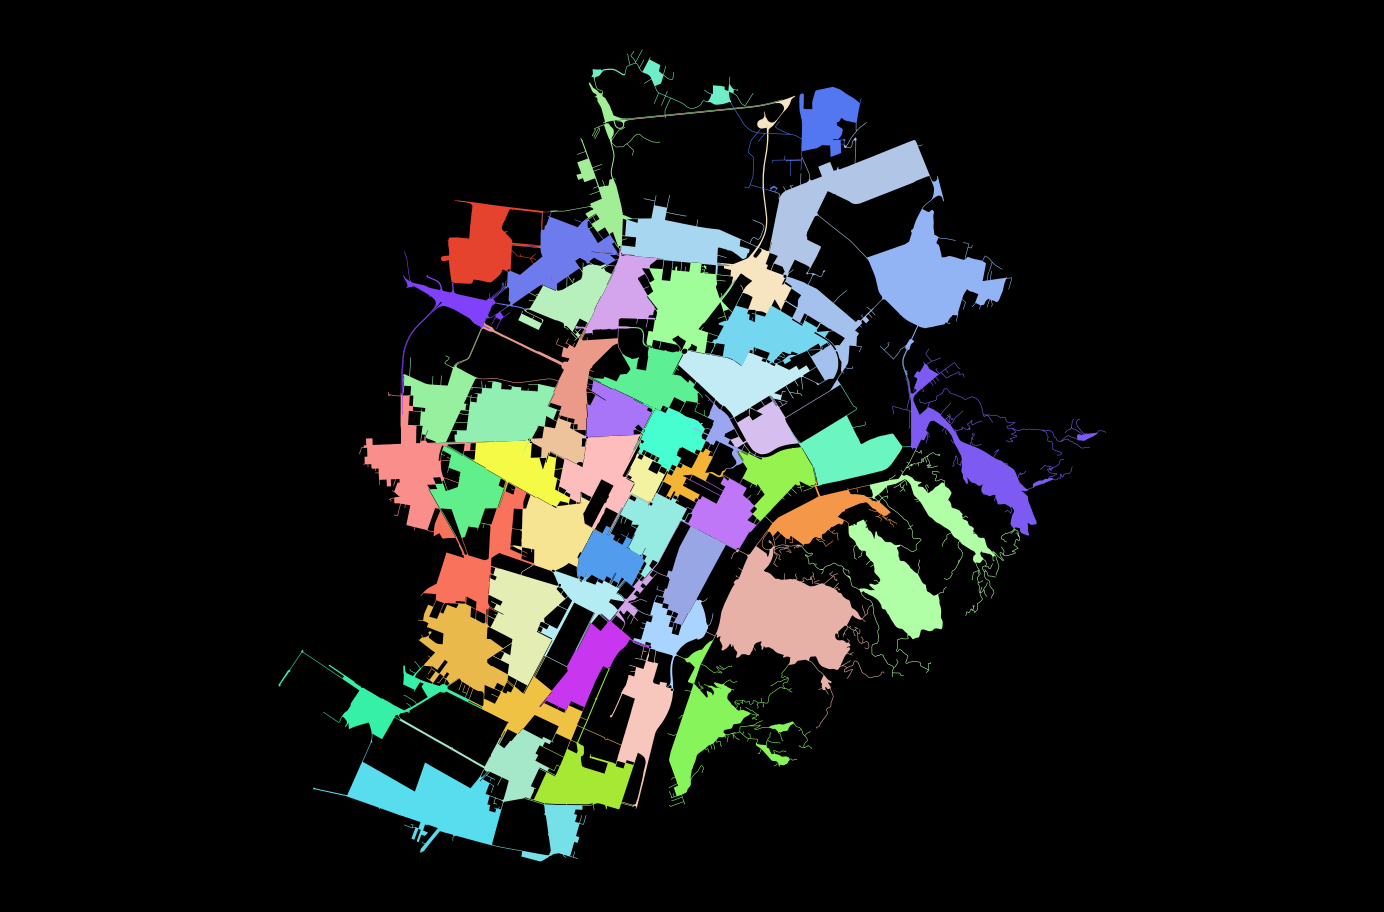

In [21]:
fig = ci.plot_gdf(partitions, column = 'p_rad', title = '', geometry_size = 1.5, cmap = cmap, black_background = True, 
                  legend = False, figsize = (15, 10))

In [22]:
nodes_graph = ci.district_to_nodes_from_polygons(nodes_graph, partitions, column)
nodes_graph[column] = nodes_graph[column].astype(int)

nodes_graph = ci.amend_nodes_membership(nodes_graph, edges_graph, column, min_size_district)
   
# assigning gateways
nodes_graph = ci.find_gateways(nodes_graph, edges_graph, column)

**Visualisation**

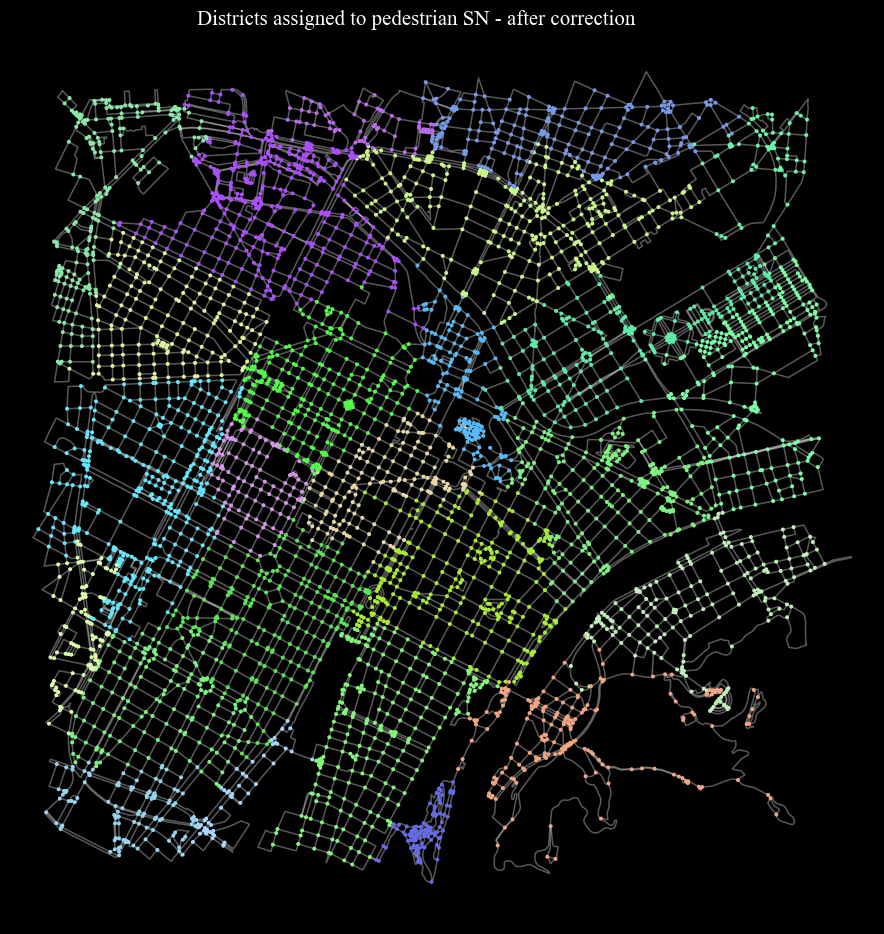

In [23]:
column = 'p_rad'
nodes_graph['district'] = nodes_graph[column].astype(int)
cmap = ci.rand_cmap(nlabels = len(nodes_graph['district'].unique()), type_color='bright')
fig = ci.plot_gdf(nodes_graph, column = column, title = 'Districts assigned to pedestrian SN - after correction', 
               cmap = cmap, geometry_size = 3.5, base_map_gdf = edges_graph, base_map_color = 'white', 
                  base_map_alpha = 0.35, black_background = True, legend = False, figsize = (10,10))

## Barrier Identification
### Download and preparation

In [24]:
download_method = 'OSMplace'
place = "Turin, Italy"
road_barriers = ci.road_barriers(place = place, download_method = download_method, epsg= epsg,
                                 include_primary = True, include_secondary = False)
water_barriers = ci.water_barriers(place = place, download_method = download_method, epsg= epsg)
railway_barriers = ci.railway_barriers(place = place, download_method = download_method, epsg= epsg)
park_barriers = ci.park_barriers(place = place, download_method = download_method, epsg= epsg, min_area = 100000)

barriers = pd.concat([road_barriers, water_barriers, railway_barriers, park_barriers], ignore_index=True)
barriers.reset_index(inplace = True, drop = True)
barriers['barrierID'] = barriers.index.astype(int)

C:\Users\gfilo\AppData\Local\miniconda3\envs\cityImage\Lib\site-packages\cityImage\barriers.py:117: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  sea = sea.unary_union


**Visualisation**

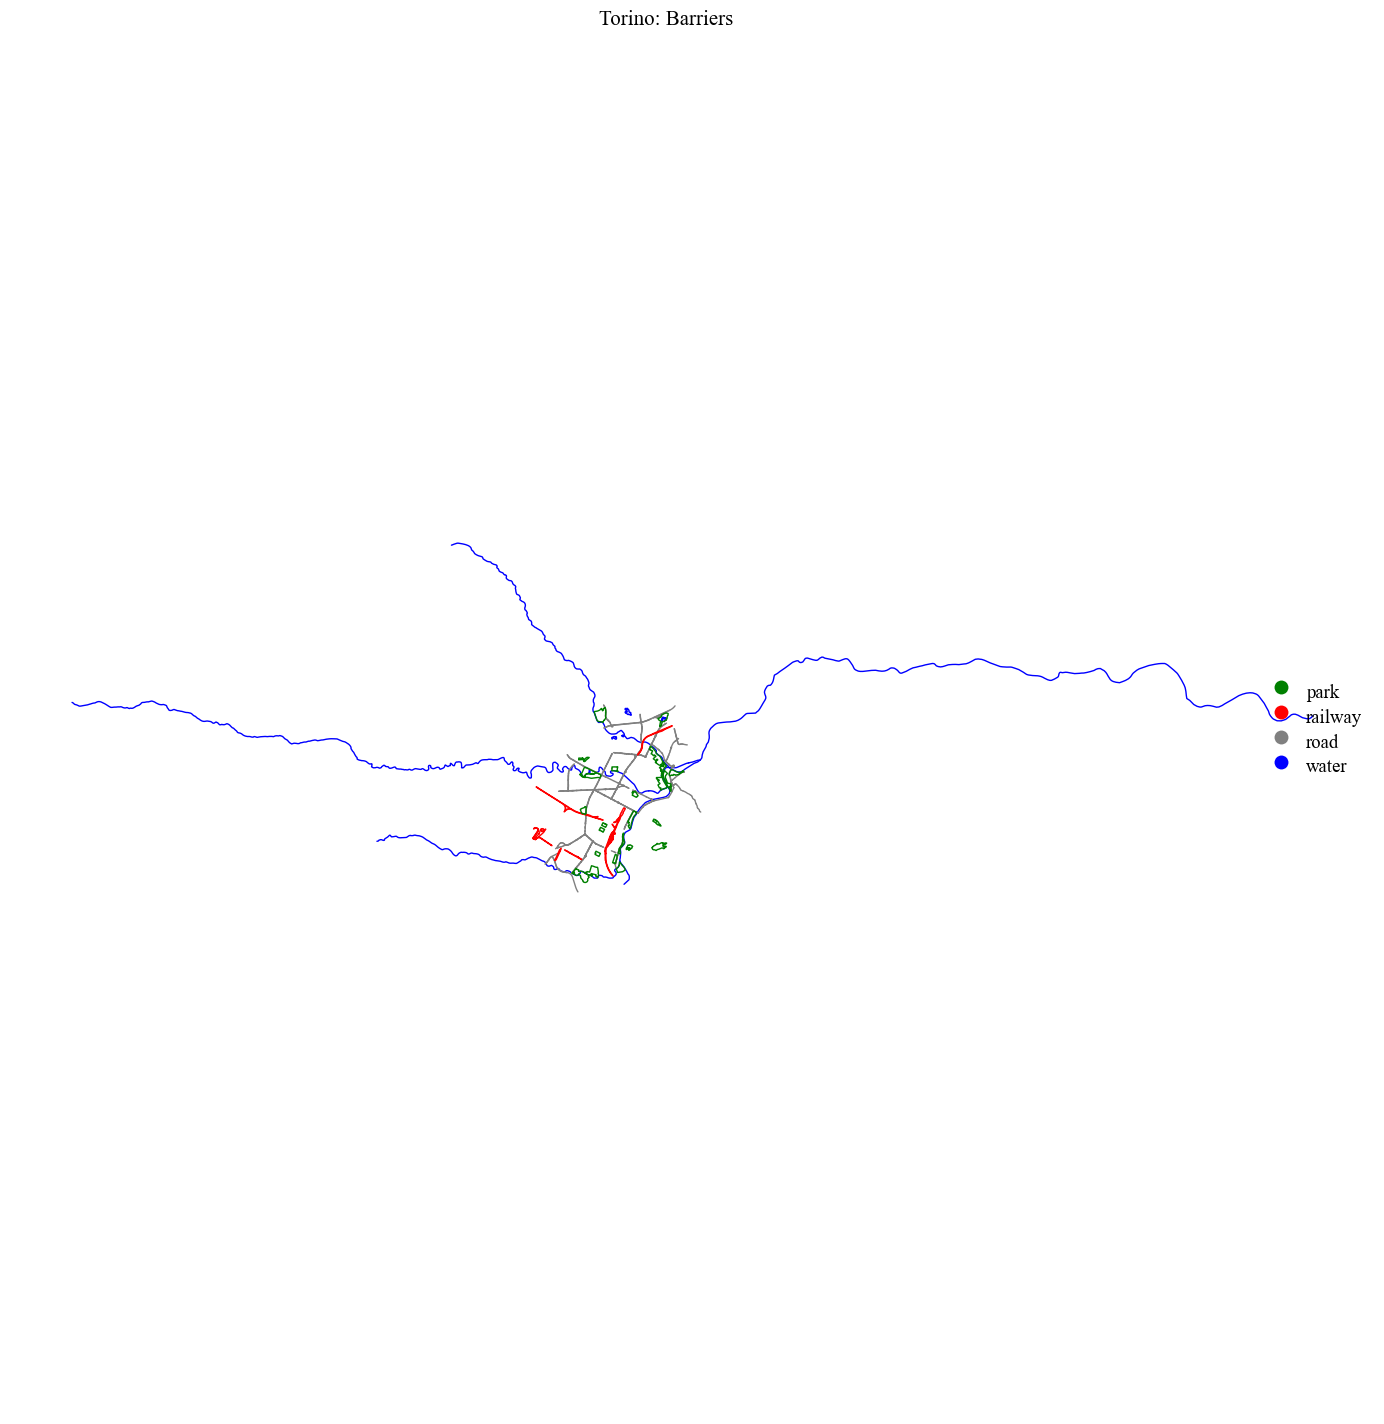

In [25]:
from matplotlib.colors import LinearSegmentedColormap

barriers.sort_values(by = 'barrier_type', ascending = False, inplace = True)  
colors = ['green', 'red', 'gray', 'blue']

cmap = LinearSegmentedColormap.from_list('cmap', colors, N=len(colors))
fig = ci.plot_gdf(gdf = barriers, column = 'barrier_type', black_background = False, title = city_name+': Barriers', 
                  legend = True, cmap = cmap)

### Incorporating Barriers into the Street Network

In [26]:
# clipping barriers to case study area
envelope = edges_graph.unary_union.envelope
barriers_within = barriers[barriers.intersects(edges_graph.unary_union.envelope)]

# Street Segments Along and Within Positive Barriers
sindex = edges_graph.sindex
# rivers
edges_graph = ci.along_water(edges_graph, barriers_within)
# parks
edges_graph = ci.along_within_parks(edges_graph, barriers_within)
# altogheter
edges_graph['p_barr'] = edges_graph['a_rivers']+edges_graph['w_parks']
edges_graph['p_barr'] = edges_graph.apply(lambda row: list(set(row['p_barr'])), axis = 1)

# Street Segments Along Negative Barriers
tmp = barriers_within[barriers_within['barrier_type'].isin(['railway', 'road'])]
edges_graph['n_barr'] = edges_graph.apply(lambda row: ci.barriers_along(row['edgeID'], edges_graph, tmp, sindex,
                                            offset = 25), axis = 1)

# Street Segments Crossing any kind of barrier but parks: Structuring Barriers
edges_graph = ci.assign_structuring_barriers(edges_graph, barriers_within)

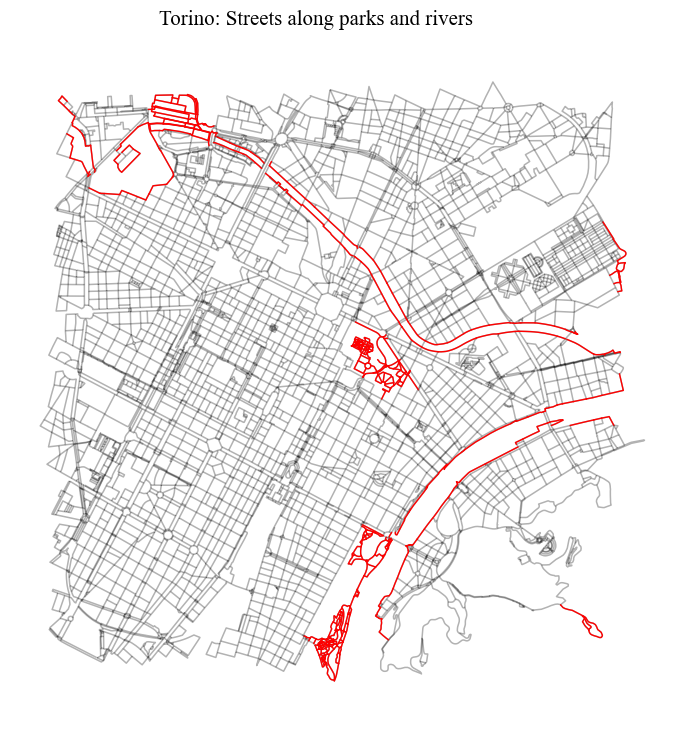

In [27]:
# positive barriers
edges_graph['p_bool'] = edges_graph.apply(lambda row: True if len(row['p_barr']) > 0 else False, axis = 1)
tmp = edges_graph[edges_graph.p_bool == True].copy()

# base map
base_map_dict = {'base_map_gdf': edges_graph, 'base_map_alpha' : 0.3, 'base_map_color' : 'black'}
fig = ci.plot_gdf(tmp, black_background = False, figsize = (8, 8), color = 'red', title = city_name+': Streets along parks and rivers', 
              legend = False, **base_map_dict)

In [56]:
edges_graph['lit'] = edges_graph['lit'].astype(int)
edges_graph["lit_m"] = np.where(
    (edges_graph["lit"] != 1) & (~edges_graph["highway"].isin(['primary', 'secondary', 'tertiary', 'residential'])),
    0,
    1  # or np.nan or whatever default
)

In [59]:
# converting list fields to string
to_convert = ['a_rivers', 'w_parks','n_barr', 'p_barr']
edges_graph_string = edges_graph.copy()
for column in to_convert: 
    edges_graph_string[column] = edges_graph_string[column].astype(str)

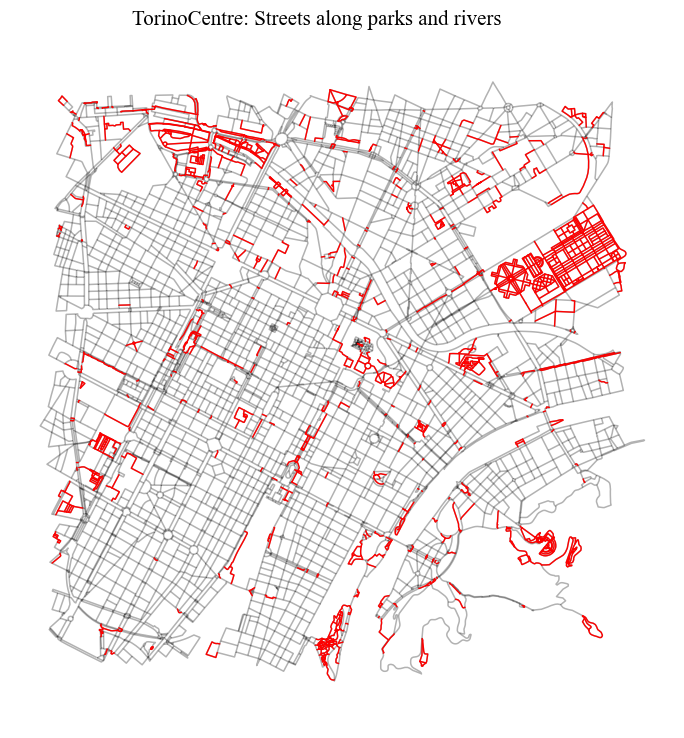

In [60]:
tmp = edges_graph[edges_graph.lit_m != 1].copy()
# base map
base_map_dict = {'base_map_gdf': edges_graph, 'base_map_alpha' : 0.3, 'base_map_color' : 'black'}
fig = ci.plot_gdf(tmp, black_background = False, figsize = (8, 8), color = 'red', title = city_name+': Streets along parks and rivers', 
              legend = False, **base_map_dict)

**Saving**

In [62]:
nodes_graph = nodes_graph.set_crs(crs)
edges_graph_string = edges_graph_string.set_crs(crs)

In [63]:
# Convert all numerical columns to standard Python types

nodes_graph = ci.convert_numeric_columns(nodes_graph)
edges_graph_string = ci.convert_numeric_columns(edges_graph_string)
nodesDual_graph = ci.convert_numeric_columns(nodesDual_graph)

In [64]:
city_name = 'TorinoCentre'
output_path = '../output/'+city_name

# barriers
barriers.to_file(output_path+"_barriers.gpkg", driver="GPKG")

# graph
nodes_graph.drop(['old_nodeIDs'], errors = 'ignore', axis = 1).to_file(output_path+"_nodes.gpkg", driver="GPKG")
edges_graph_string['lit'] = edges_graph_string['lit'].astype(int)
edges_graph_string.to_file(output_path+"_edges.gpkg", driver="GPKG")
nodesDual_graph.drop("intersecting", axis = 1).to_file(output_path+"_nodesDual_graph.gpkg", driver="GPKG")
edgesDual_graph.to_file(output_path+"_edgesDual_graph.gpkg", driver="GPKG")

## Identifying Buildings

In [105]:
download_method = 'distance_from_address'
place = 'Piazza Statuto, Torino'
distance = 3000

buildings = ci.get_buildings_fromOSM(download_method = download_method, distance = distance, place = place, epsg = epsg)

In [110]:
buildings = ci.gdf_multipolygon_to_polygon(buildings)
buildings = buildings.explode(index_parts=False).reset_index(drop = True)
buildings.buildingID = buildings.index
buildings.head()

historic   land_use_raw                 area  buildingID  \
0      NaN     university              8572.88           0   
1      NaN         school              2996.33           1   
2      NaN  train_station             24057.88           2   
3      NaN    residential              2140.96           3   
4      yes    residential              3205.92           4   

                                            geometry  
0  POLYGON ((1397229.172 4991335.060, 1397254.305...  
1  POLYGON ((1397105.509 4991307.588, 1397121.048...  
2  POLYGON ((1395849.959 4990647.479, 1395858.231...  
3  POLYGON ((1395104.311 4991994.446, 1395115.828...  
4  POLYGON ((1396395.000 4991393.616, 1396396.359...

**Visualisation** 

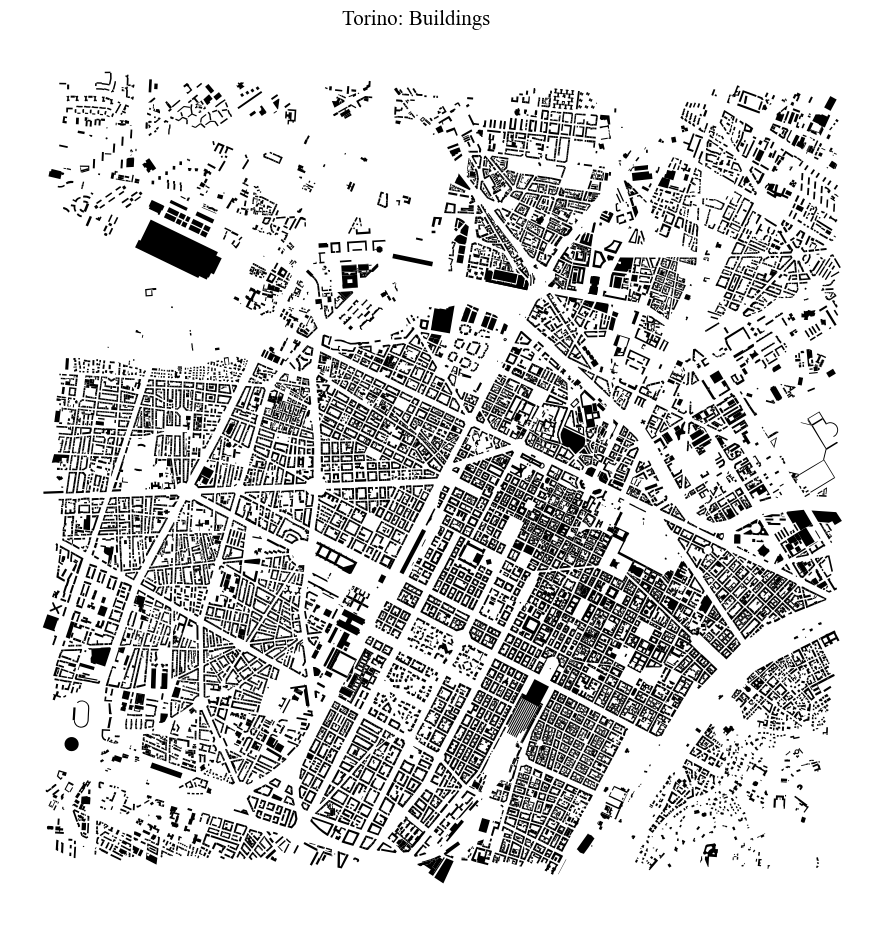

In [111]:
fig = ci.plot_gdf(buildings, scheme = None,  black_background = False, figsize = (10,10), 
                  color = 'black',title = city_name+': Buildings')

## Pragmatic Component

In [112]:
# introducing classifications and possible entries

adult_entertainment = ['brothel','casino', 'swingerclub', 'stripclub', 'nightclub', 'gambling'] 
    
agriculture = ['shed', 'silo', 'greenhouse', 'stable', 'agricultural and forestry',  'greenhouse (botany)',  
               'building in the botanical garden']

attractions = ['attractions',   'attraction','aquarium', 'monument',  'gatehouse', 'terrace', 'tower', 'attraction and leisure',
               'information', 'viewpoint', 'tourist information center', 'recreation and amusement park',  'zoo',
               'exhibition hall', 'trade hall', 'boathouse', 'bath house, thermal baths', 'entertainment hall', 'sauna',
               'fountain', 'palace', 'exhibition_hall', 'pavilion', 'ruins']

business_services = ['bank', 'service','offices', 'foundation', 'office', 'atm', 'bureau_de_change', 'post_office', 
              'post_office;atm', 'coworking_space', 'conference_centre',  'trade and services', 'trade and services building',
                      'customs office', 'insurance', 'tax_office', 'post', 'administrative building',  'facility building',
                      'residential building with trade and services', 'data_center', 'tax office']

commercial = [ 'commercial',  'retail', 'pharmacy', 'commercial;educa', 'shop', 'supermarket', 'books', 'commercial services',
              'commercial land', 'car_wash', 'internet_cafe', 'driving_school', 'marketplace', 'fuel', 'car_sharing', 
              'commercial and industry buidling',  'crematorium', 'commercial building', 'commercial and industry building',  
              'commercial building to traffic facilities (general)', 'funeral parlor', 'gas station', 'car wash',
              'pumping station','boat_rental', 'boat_sharing',  'bicycle_rental', 'car_rental', 'dive_centre', 'market', 'toy_library']

culture = ['club_house','gallery', 'arts_centre','cultural facility', 'cultural_centre', 'theatre', 'cinema', 'studio',
            'exhibition_centre', 'music_school', 'theater','castle', 'museum', 'culture', 'events_venue']
    
eating_drinking = ['bbq', 'restaurant', 'fast_food', 'cafe', 'bar',  'pub', 'accommodation, eating and drinking', 
                   'ice_cream', 'kitchen', 'food_court', 'cafe;restaurant', 'biergarten']

education_research = ['university', 'research', 'university building', 'education and research', 'research_institute',
                     'research_institu']

emergency_service = [ 'fire brigade','fire_station','police', 'emergency_service', 'resque_station', 'ranger_station',  
                     'security']

general_education = ['school', 'college', 'kindergarten', 'education', 'education and health', 'childcare',
             'language_school', 'children home',  'nursery',  'general education school']

hospitality = [ 'hotel',  'hostel', 'guest_house',  'building for accommodation',  'hotel, motel, pension',  'refuge']

industrial = ['industrial', 'factory', 'construction', 'manufacturing and production', 'gasometer', 'workshop', 
              'production building', 'manufacture', 'industrial;yes', 'post_depot', 'oficinas']

medical_care = ['hospital', 'doctors', 'dentist','clinic','veterinary', 'medical care', 'nursing_home',  
                'sanatorium, nursing home', 'retirement home', 'healthcare', 'mortuary']

military_detainment = ['general aviation', 'barracks',  'military', 'penitentiary', 'prison', 'guardhouse']

other = ['toilets', 'picnic_site','hut', 'storage_tank', 'canopy','toilet',  'bunker, shelter', 'shelter','warehouse', 
         'converter',    'garage', 'garages','parking', 'block', 'roof', 'no', 'exempt','exempt 121a', 'bicycle_parking', 'roof;yes', 
         'tent', 'demolished', 'annex', 'bungalow', 'collapsed', 'carport', 'kiosk', 'air-supported'] 

public = ['townhall', 'public_building',  'library','civic', 'courthouse', 'public', 'embassy',
          'public infrastructure', 'community_centre', 'court',  'district government', 'government',
          'residential building with public facilities', 'animal_shelter']

religious = ['church', 'place_of_worship','convent', 'rectory', 'chapel', 'religious building', 'monastery', 'nuns home',
              'vocational school',  'cathedral', 'religious buildings', 'basilica', 'place_of_mourning', 'synagogue', 'religious', 'mosque']

residential = [ 'apartments', None, 'NaN', 'residential','flats', 'houses', 'building', 'residential land', 
               'residential building', 'student dorm', 'building usage mixed with living', 'house'
              'exempt', 'apartments 4-6 units', 'apartments 7 units above', 'residential condo unit', 'mixed use res/comm',
             'residential three family', 'residential two family','house', 'commercial condo unit', 'condominium master',
               'condominium parking', 'residential single family', 'detached', 'yes;apartments', 'semidetached_house', 'villa']

social = ['social_facility', 'community_centre', 'community buidling', 'dormitory', 'social_centre', 'social serives building', 
         'social services',  'community hall',  'commercial social facility',  'recreational']

sport = ['stadium', 'sport and entertainment', 'sports or exercise facility', 'gym', 'sports building', 'sports hall', 
         'horse riding school',  'swimming pool',  'sport hall', 'bowling hall',  'indoor swimming pool', 'grandstand', 'sports', 'sports_hall',
        'sports_centre', 'riding_hall']

transport = ['transport', 'road transport', 'station', 'subway_entrance', 'bus_station', 'shipping facility building', 
             'train_station',  'railway building',  'railway station and london underground station', 'railway station',
            'london underground station', 'light rapid transit station', 'light rapid transit station and railway station', 'transportation',
            'bridge']

utilities = ['gas supply', 'electricity supply', 'electricity substation', 'waste treatment building',
            'water supply', 'waste water treatment plant', 'smokestack', 'supply systems', 'waste management', 'water works',
              'heating plant', 'boiler house',  'telecommunication', 'transformer_tower']

rural = ['farm', 'barn', 'animal_breeding']

In [113]:
buildings['land_use_raw'] = buildings['land_use_raw'].str.lower()
categories = [adult_entertainment, agriculture, attractions, business_services, commercial, culture, eating_drinking,
       education_research, emergency_service, general_education, hospitality, industrial, medical_care, military_detainment,
       other, public, religious, residential, social, sport, transport, utilities, rural]
strings = ['adult_entertainment', 'agriculture', 'attractions', 'business_services', 'commercial', 'culture', 'eating_drinking',
       'education_research', 'emergency_service', 'general_education', 'hospitality', 'industrial', 'medical_care', 
           'military_detainment', 'other', 'public', 'religious', 'residential', 'social', 'sport', 'transport', 'utilities', 'rural']

all_uses = [item for sublist in categories for item in sublist]
land_uses = list(buildings.land_use_raw.unique())
to_categorise = [item for item in land_uses if item not in all_uses]

# shows existing raw categories to classify
to_categorise

[]

In [114]:
# and finally classify
buildings = ci.classify_land_use(buildings, 'land_use','land_use_raw', categories, strings)
# and compute the pragmatic score
buildings = ci.pragmatic_score(buildings, research_radius = 200)

**URBAN DMA Categorisation**

The land use can also be cagtegorised into 3 categories see https://journals.sagepub.com/doi/full/10.1177/0042098018819727

In [115]:
visit = ['adult_entertainment', 'attractions', 'culture', 'eating_drinking', 'sport', 'religious', 'social', 'sport']
work = ['agriculture', 'business_services', 'commercial', 'education_research', 'emergency_service', 'general_education',
        'industrial','medical_care', 'military_detainment','public', 'transport','utilities', 'rural']
live = ['hospitality', 'residential'] 

categories = [visit, work, live, other]
strings = ['visit', 'work', 'live']
buildings = ci.classify_land_use(buildings, 'DMA','land_use', categories, strings)

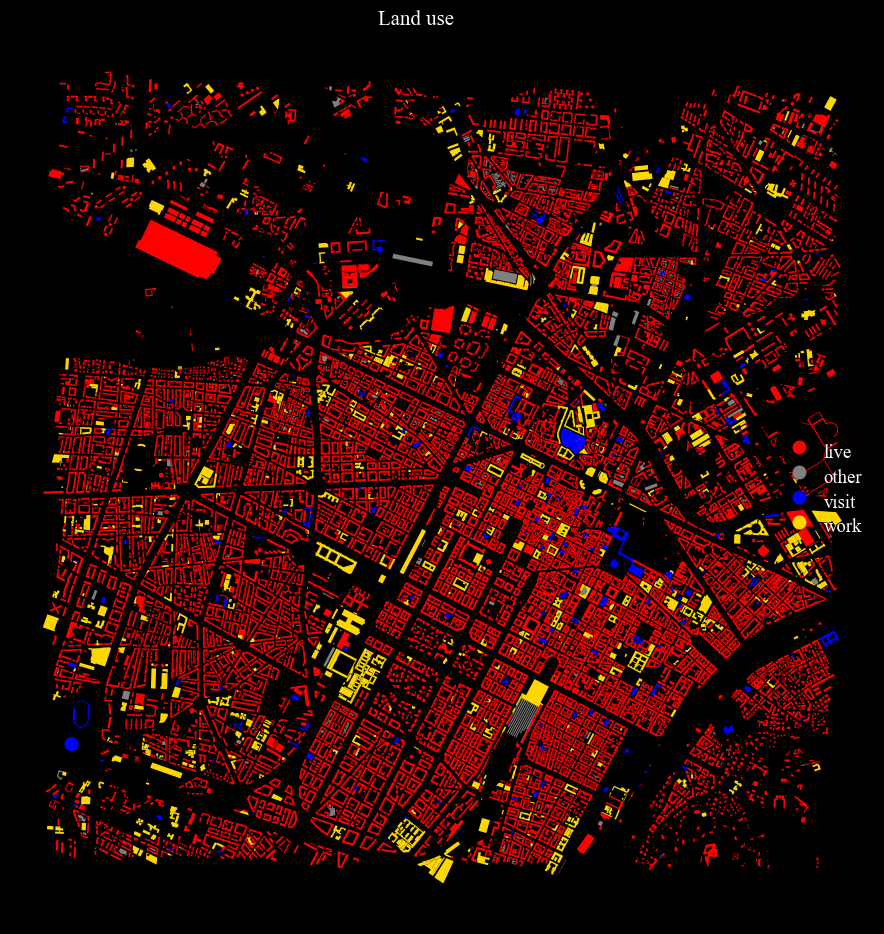

In [116]:
# visualising
from matplotlib.colors import LinearSegmentedColormap
colors = ['red', 'gray', 'blue', 'gold']
cmap = LinearSegmentedColormap.from_list('cmap', colors, N=len(colors))
fig = ci.plot_gdf(buildings, column = 'DMA', title = 'Land use', black_background = True, figsize = (10,10), cmap = cmap,
            legend = True)

In [117]:
buildings.to_file(output_path+"_buildings.gpkg", driver="GPKG")